In [1]:
import pickle
from matplotlib.ticker import FuncFormatter
def format_thousands(value, pos):
    return f'{value / 1000:.0f}K'

show_imp = True

def pickle_load(filename):
    with open(filename, 'rb') as f:
        obj = pickle.load(f)
    return obj

# mapper = 'jordan_wigner'
mapper = 'bravyi_kitaev'
# mapper = 'parity'

PH_data_list = pickle_load(f'runs_final/{mapper}/PH_data.pickle') + pickle_load(f'runs_final/random/PH_data.pickle')
Tetris_data_list = pickle_load(f'runs_final/{mapper}/Tetris_lookahead_data.pickle') + pickle_load(f'runs_final/random/Tetris_lookahead_data.pickle')
Max_cancel_data_list = pickle_load(f'runs_final/{mapper}/Max_cancel_data.pickle') + pickle_load(f'runs_final/random/Max_cancel_data.pickle')
Tetris_without_lh_data_list = pickle_load(f'runs_final/{mapper}/Tetris_data.pickle') + pickle_load(f'runs_final/random/Tetris_data.pickle')

# PH_data_list = pickle_load(f'runs_final/PH_data.pickle')
# Tetris_data_list = pickle_load(f'runs_final/Tetris_data.pickle')
# Max_cancel_data_list = pickle_load(f'runs_final/Max_cancel_data.pickle')

In [2]:
from qiskit import QuantumCircuit
from qiskit import QuantumCircuit, transpile, pulse
from qiskit.providers.fake_provider import FakeManhattan
categories = []
ph_cx_cancel_ratio = []
tetris_cx_cancel_ratio = []
max_cancel_cx_cancel_ratio = []

ph_swaps = []
tetris_swaps = []
max_cancel_swaps = []

ph_cnots = []
tetris_cnots = []
max_cancel_cnots = []

ph_depth = []
tetris_depth = []
max_cancel_depth = []

backend = FakeManhattan()

for i, (ph_data, tetris_data, max_cancel_data, tetris_without_lh_data) in enumerate(zip(PH_data_list, Tetris_data_list, Max_cancel_data_list, Tetris_without_lh_data_list)):
    mole, ph = ph_data
    mole, tetris = tetris_data
    mole, max_cancel = max_cancel_data
    mole, tetris_without_lh = tetris_without_lh_data
    categories.append(mole)
    
    original_cx_count = tetris_without_lh['original CNOT count']
    ph_cx_cancel_ratio.append(1.0 - 1.0 * (ph['CNOT'] - ph['PH_swap_count'] * 3) / original_cx_count)
    # tetris_cx_cancel_ratio.append(1.0 - 1.0 * tetris['tetris_cx_count'] / original_cx_count)
    tetris_cx_cancel_ratio.append(1.0 - 1.0 * (tetris['CNOT'] - tetris['tetris_swap_count'] * 3) / original_cx_count)
    max_cancel_cx_cancel_ratio.append(1.0 - 1.0 * (max_cancel['CNOT'] - max_cancel['tetris_swap_count'] * 3) / original_cx_count)
    
    ph['CX_cancel_ratio'] = 1.0 - 1.0 * (ph['CNOT'] - ph['PH_swap_count'] * 3) / original_cx_count
    tetris['CX_cancel_ratio'] = 1.0 - 1.0 * (tetris['CNOT'] - tetris['tetris_swap_count'] * 3) / original_cx_count
    max_cancel['CX_cancel_ratio'] = 1.0 - 1.0 * (max_cancel['CNOT'] - max_cancel['tetris_swap_count'] * 3) / original_cx_count
    
    ph['Swap_insertion'] = ph['PH_swap_count']
    tetris['Swap_insertion'] = tetris['tetris_swap_count']
    max_cancel['Swap_insertion'] = max_cancel['tetris_swap_count']
    

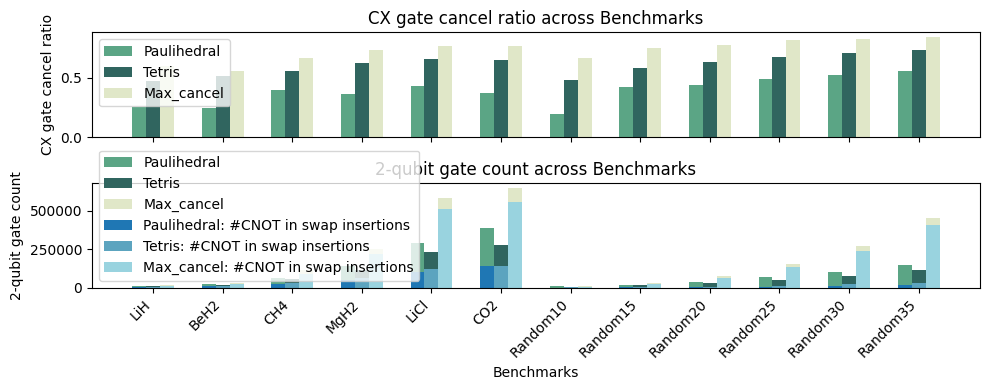

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data for metrics (replace these with your actual data)
benchmarks = ['LiH', 'BeH2', 'CH4', 'MgH2', 'LiCl', 'CO2', 'Random10', 'Random15', 'Random20', 'Random25', 'Random30', 'Random35']
# benchmarks = ['LiH', 'BeH2', 'CH4', 'MgH2', 'LiCl', 'CO2']
# benchmarks = ['UCC-10', 'UCC-15', 'UCC-20', 'UCC-25', 'UCC-30', 'UCC-35']

experiments = ['Paulihedral', 'Tetris', 'Max_cancel']

def get_metric_data(metric_name):
    data = []
    for i, benchmark in enumerate(benchmarks):
        bars = []
        for data_list in [PH_data_list, Tetris_data_list, Max_cancel_data_list]:
            bars.append(data_list[i][1][metric_name])
        data.append(bars)
    return np.array(data)

# Sample metrics data (replace these with your actual metrics data)
metrics_data = {
    'CX gate cancel ratio': get_metric_data('CX_cancel_ratio'),
    # 'Swap insertions': get_metric_data('Swap_insertion'),
    '2-qubit gate count': get_metric_data('CNOT'),
    # 'Total gate count': get_metric_data('Total'),
    # 'Depth': get_metric_data('Depth'),
    # 'Duration': get_metric_data('duration'),
    # 'ESP improvement': np.random.rand(len(benchmarks), len(experiments))
}

# Colors for the experiments (cool tones)
experiment_colors = ['#5ba585', '#30655f', '#e0e7c8']  # Adjust shades for lighter transparent colors
experiment_colors2 = ['#1f77b4', '#5ca4bf', '#99d3df']  

num_metrics = len(metrics_data)
fig, axs = plt.subplots(num_metrics, 1, figsize=(10, num_metrics * 2), sharex=True)

# Plotting each metric with all three experiments
for i, (metric, data) in enumerate(metrics_data.items()):
    ax = axs[i]
    bar_width = 0.2
    x = np.arange(len(benchmarks))
    
    if metric == 'ESP improvement':
        data = []
        for i, benchmark in enumerate(benchmarks):
            bars = Tetris_data_list[i][1]['ESP_imp']
            data.append(bars)
        data = np.array(data)
        ax.bar(x + 1 * bar_width, data, width=bar_width, label='log10 of the ESP improvement compared with PH', color=experiment_colors2[1])
        ax.hlines(y=0, xmin=-1, xmax=12, linewidth=1, color='black')
        ax.set_ylabel(metric)
        ax.legend()
        continue
    
    for j, experiment in enumerate(experiments):
        ax.bar(x + j * bar_width, data[:, j], width=bar_width, label=experiment, color=experiment_colors[j])
    
    if metric == '2-qubit gate count':
        data = get_metric_data('Swap_insertion') * 3
        for j, experiment in enumerate(experiments):
            ax.bar(x + j * bar_width, data[:, j], width=bar_width, label=experiment + ': #CNOT in swap insertions', color=experiment_colors2[j])

    ax.set_ylabel(metric)
    ax.legend()
    ax.set_title(f'{metric} across Benchmarks')

bar_width = 0.2
# Setting x-axis label for the bottom subplot only
axs[-1].set_xlabel('Benchmarks')
axs[-1].set_xticks(np.arange(len(benchmarks)) + bar_width * (len(experiments) - 1) / 2)
axs[-1].set_xticklabels(benchmarks, rotation=45, ha='right')
plt.subplots_adjust(wspace=0.4)
plt.gca().set_aspect('auto', adjustable='box')

plt.tight_layout()

# Save the figure as PDF
plt.savefig('metrics_figure.pdf')
plt.show()


In [4]:
print(get_metric_data('CNOT'))

[[ 10074   9043  15216]
 [ 22057  19267  29143]
 [ 64163  57568 111909]
 [142160 113962 254125]
 [292658 233044 585429]
 [384969 276360 648790]
 [  7647   5497   9836]
 [ 17273  14076  31131]
 [ 36477  28524  76225]
 [ 65999  49800 156122]
 [102287  76752 273848]
 [148625 112619 454320]]


In [5]:
# import math
output = get_metric_data('Depth')
imp = []
for row in output:
    number = 100* (row[1]-row[0])/row[0]
    imp.append(round(number,1))
print(output)
for i in range(6):
    # print(f'{round(output[i][1]/1000000, 1)}M')
    # print(f'{round(output[i][1]/1000, 1)}k')

    print(f'{imp[i]}%')


[[ 10790   9427  14628]
 [ 23140  20004  27761]
 [ 61473  54932  97644]
 [139653 107594 218509]
 [285789 219601 480320]
 [381185 259613 552750]
 [  9366   7131   9361]
 [ 18877  16267  24741]
 [ 37672  30110  53108]
 [ 64772  49853 101299]
 [ 95662  72693 173032]
 [137332 101828 272136]]
-12.6%
-13.6%
-10.6%
-23.0%
-23.2%
-31.9%


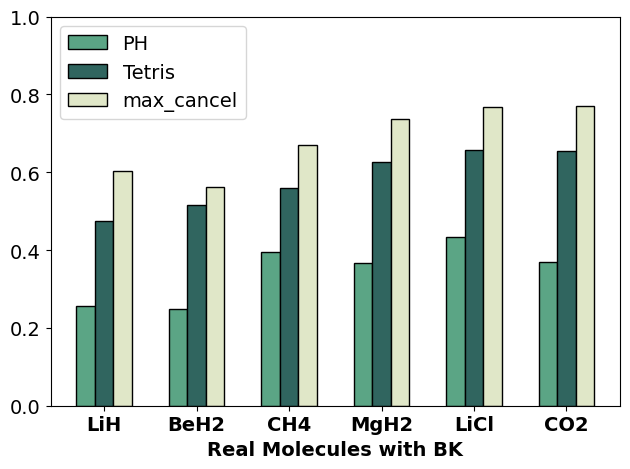

In [6]:
# Sample data
x_values = np.array(['LiH', 'BeH2', 'CH4', 'MgH2', 'LiCl', 'CO2'])  # X-axis values
ph = []
tetris = []
max_cancel = []
for i in get_metric_data('CX_cancel_ratio')[0:6]:
    ph.append(i[0])
    tetris.append(i[1])
    max_cancel.append(i[2])

width = 0.2  # Width of each bar

# Create a figure and axis
fig, ax = plt.subplots()

# Set the bar positions
x_positions = np.arange(len(x_values))

# Create the bars
# Custom colors for bars (in hexadecimal format)
colors = ['#5ba585', '#30655f', '#e0e7c8']
bar1_plot = ax.bar(x_positions - width, ph, width, label='PH',color=colors[0],edgecolor='black')
bar2_plot = ax.bar(x_positions, tetris, width, label='Tetris',color=colors[1],edgecolor='black')
bar3_plot = ax.bar(x_positions + width, max_cancel, width, label='max_cancel',color=colors[2],edgecolor='black')

# Set the x-axis labels
ax.set_xticks(x_positions)
ax.set_xticklabels(x_values, fontsize=14, fontweight='bold')  # Set font size for x-axis tick labels

# Set the y-axis label font size
ax.set_ylabel('Values', fontsize=14,fontweight='bold')  # Set font size for y-axis label

# Set the x-axis label font size
ax.set_xlabel('X-Axis', fontsize=14,fontweight='bold')  # Set font size for x-axis label

# Set font size for y-axis tick labels
ax.tick_params(axis='y', labelsize=14)

# Add labels and a legend
ax.set_ylim(0, 1)
ax.set_xlabel('Real Molecules with BK')
# ax.set_xlabel('Real Molecules with JW')

ax.set_ylabel('')
# ax.set_title('CX Gate Cancel Ratio',fontsize = 15)
ax.legend(fontsize=14)

# Show the plot
plt.tight_layout()
plt.savefig('exp_figs/gcr_molecule_bk.pdf')
plt.show()

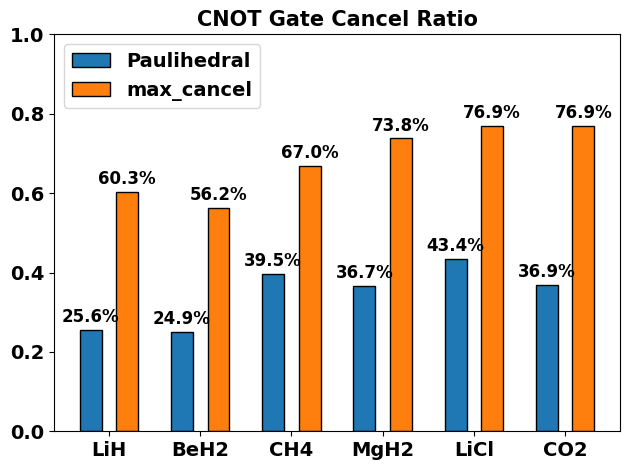

In [7]:
# Sample data
x_values = np.array(['LiH', 'BeH2', 'CH4', 'MgH2', 'LiCl', 'CO2'])  # X-axis values
ph = []
tetris = []
max_cancel = []
for i in get_metric_data('CX_cancel_ratio')[0:6]:
    ph.append(i[0])
    tetris.append(i[1])
    max_cancel.append(i[2])

width = 0.4  # Width of each bar

# Create a figure anax = plt.subplots()
fig, ax = plt.subplots()

# Set the bar positions
x_positions = np.arange(len(x_values))

# Create the bars
# Custom colors for bars (in hexadecimal format)
colors = ['#5ba585', '#30655f', '#e0e7c8']
bar1_plot = ax.bar(x_positions - width/2, ph, width * 0.6, label='Paulihedral',edgecolor='black')
bar3_plot = ax.bar(x_positions + width/2, max_cancel, width * 0.6, label='max_cancel',edgecolor='black')
for i, (ph_gcr, max_cancel_gcr) in enumerate(zip(ph, max_cancel)):
    ax.text(x_positions[i] - width/2, ph_gcr +.01, "{:.1f}%".format(ph_gcr*100.), ha='center', va='bottom', fontsize=12, weight='bold')
    ax.text(x_positions[i] + width/2, max_cancel_gcr + .01, "{:.1f}%".format(max_cancel_gcr*100.), ha='center', va='bottom', fontsize=12, weight='bold')

# Set the x-axis labels
ax.set_xticks(x_positions)
ax.set_xticklabels(x_values, fontsize=14, fontweight='bold')  # Set font size for x-axis tick labels

# Set the y-axis label font size
# ax.set_ylabel('Values', fontsize=14,fontweight='bold')  # Set font size for y-axis label

# Set the x-axis label font size
# ax.set_xlabel('X-Axis', fontsize=14,fontweight='bold')  # Set font size for x-axis label

# Set font size for y-axis tick labels
ax.tick_params(axis='y', labelsize=14)
ytick_labels = ax.get_yticklabels()
for label in ytick_labels:
    label.set_fontweight('bold')

# Add labels and a legend
ax.set_ylim(0, 1)
# ax.set_xlabel('Real Molecules with BK')
# ax.set_xlabel('Real Molecules with JW')

ax.set_ylabel('')
ax.set_title('CNOT Gate Cancel Ratio',fontsize = 15, weight='bold')
legend=ax.legend(fontsize=14, loc='upper left')
for text in legend.get_texts():
    text.set_fontweight('bold')

# Show the plot
plt.tight_layout()
plt.savefig('exp_figs/maxCancel_BK.pdf')
plt.show()

[0.196524064171123, 0.41922794117647055, 0.44292604501607713, 0.4863004362050164, 0.5231668591224019, 0.5579455432558628]


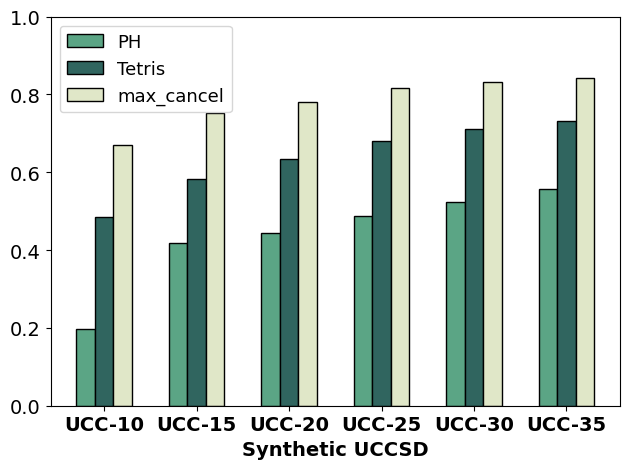

In [8]:
x_values = np.array(['UCC-10', 'UCC-15', 'UCC-20', 'UCC-25', 'UCC-30', 'UCC-35'])  # X-axis values
ph = []
tetris = []
max_cancel = []
for i in get_metric_data('CX_cancel_ratio')[6:12]:
    ph.append(i[0])
    tetris.append(i[1])
    max_cancel.append(i[2])
print(ph)
width = 0.2  # Width of each bar

# Create a figure and axis
fig, ax = plt.subplots()

# Set the bar positions
x_positions = np.arange(len(x_values))

# Create the bars
# Custom colors for bars (in hexadecimal format)
colors = ['#5ba585', '#30655f', '#e0e7c8']
bar1_plot = ax.bar(x_positions - width, ph, width, label='PH',color=colors[0],edgecolor='black')
bar2_plot = ax.bar(x_positions, tetris, width, label='Tetris',color=colors[1],edgecolor='black')
bar3_plot = ax.bar(x_positions + width, max_cancel, width, label='max_cancel',color=colors[2],edgecolor='black')

# Set the x-axis labels
ax.set_xticks(x_positions)
ax.set_xticklabels(x_values, fontsize=14,fontweight='bold')  # Set font size for x-axis tick labels

# Set the y-axis label font size
ax.set_ylabel('Values', fontsize=14,fontweight='bold')  # Set font size for y-axis label

# Set the x-axis label font size
ax.set_xlabel('X-Axis', fontsize=14,fontweight='bold')  # Set font size for x-axis label

# Set font size for y-axis tick labels
ax.tick_params(axis='y', labelsize=14)

# Add labels and a legend
ax.set_ylim(0, 1)
ax.set_xlabel('Synthetic UCCSD')
ax.set_ylabel('')
# ax.set_title('CX Gate Cancel Ratio',fontsize = 15)
ax.legend(fontsize=13)

# Show the plot
plt.tight_layout()
plt.savefig('exp_figs/gcr_random.pdf')
plt.show()

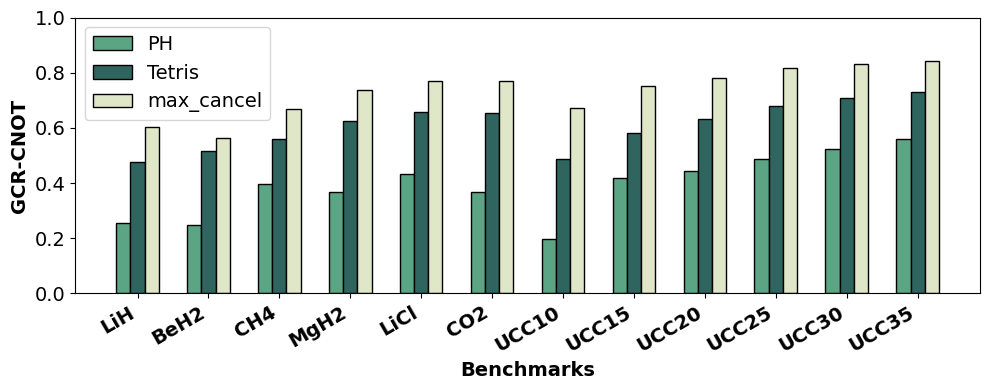

In [9]:
# Sample data
x_values = np.array(['LiH', 'BeH2', 'CH4', 'MgH2', 'LiCl', 'CO2','UCC10', 'UCC15', 'UCC20', 'UCC25', 'UCC30', 'UCC35' ])  # X-axis values
ph = []
tetris = []
max_cancel = []
for i in get_metric_data('CX_cancel_ratio'):
    ph.append(i[0])
    tetris.append(i[1])
    max_cancel.append(i[2])

width = 0.2  # Width of each bar

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, num_metrics * 2))

# Set the bar positions
x_positions = np.arange(len(x_values))

# Create the bars
# Custom colors for bars (in hexadecimal format)
colors = ['#5ba585', '#30655f', '#e0e7c8']
bar1_plot = ax.bar(x_positions - width, ph, width, label='PH',color=colors[0],edgecolor='black')
bar2_plot = ax.bar(x_positions, tetris, width, label='Tetris',color=colors[1],edgecolor='black')
bar3_plot = ax.bar(x_positions + width, max_cancel, width, label='max_cancel',color=colors[2],edgecolor='black')

# Set the x-axis labels
ax.set_xticks(x_positions)
ax.set_xticklabels(x_values, fontsize=14, fontweight='bold', rotation=30, ha='right')  # Set font size for x-axis tick labels

# Set the y-axis label font size
ax.set_ylabel('Values', fontsize=14,fontweight='bold')  # Set font size for y-axis label

# Set the x-axis label font size
ax.set_xlabel('X-Axis', fontsize=14,fontweight='bold')  # Set font size for x-axis label

# Set font size for y-axis tick labels
ax.tick_params(axis='y', labelsize=14)

# Add labels and a legend
ax.set_ylim(0, 1)
ax.set_xlabel('Benchmarks')
ax.set_ylabel('GCR-CNOT')
# ax.set_title('CX Gate Cancel Ratio',fontsize = 15)
ax.legend(fontsize=14)

# Show the plot
plt.gca().set_aspect('auto', adjustable='box')
plt.tight_layout()
# plt.savefig('exp_figs/gcr_jw.pdf')
plt.savefig('exp_figs/gcr_bk.pdf')
plt.show()

[3618, 7947, 25737, 49701, 104559, 140454]
[10074, 22057, 64163, 142160, 292658, 384969]


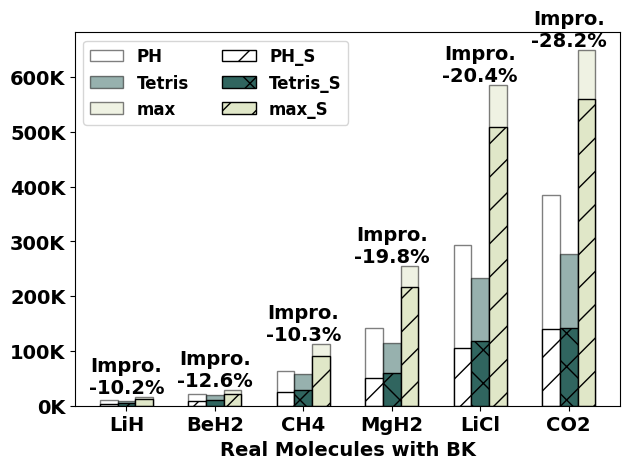

In [10]:
# Sample data
x_values = np.array(['LiH', 'BeH2', 'CH4', 'MgH2', 'LiCl', 'CO2'])  # X-axis values
# benchmarks = x_values
ph_s = []
tetris_s = []
max_cancel_s = []
for i in get_metric_data('Swap_insertion')[0:6]:
    ph_s.append(i[0]*3)
    tetris_s.append(i[1]*3)
    max_cancel_s.append(i[2]*3)

print(ph_s)

ph = []
tetris = []
max_cancel = []
for i in get_metric_data('CNOT')[0:6]:
    ph.append(i[0])
    tetris.append(i[1])
    max_cancel.append(i[2])

print(ph)

width = 0.2  # Width of each bar

# Create a figure and axis
fig, ax = plt.subplots()

# Set the bar positions
x_positions = np.arange(len(x_values))

# Create the bars
# Custom colors for bars (in hexadecimal format)
colors = ['#5ba585', '#30655f', '#e0e7c8']
colors1 = ['#5ba585', '#30655f', '#e0e7c8']

bar1_plot = ax.bar(x_positions - width, ph, width, label='PH',color='w',edgecolor='black',alpha=0.5)
bar2_plot = ax.bar(x_positions, tetris, width, label='Tetris',color=colors[1],edgecolor='black',alpha=0.5)
bar3_plot = ax.bar(x_positions + width, max_cancel, width, label='max',color=colors[2],edgecolor='black',alpha=0.5)

bar4_plot = ax.bar(x_positions - width, ph_s, width, label='PH_S',color='w',edgecolor='black', hatch='/')
bar5_plot = ax.bar(x_positions, tetris_s, width, label='Tetris_S',color=colors1[1],edgecolor='black',hatch='x')
bar6_plot = ax.bar(x_positions + width, max_cancel_s, width, label='max_S',color=colors1[2],edgecolor='black', hatch='/')
if show_imp:
    for i, pos in enumerate(x_positions):
        ax.text(pos, max_cancel[i] + 5, 'Impro.\n{:.1f}%'.format((tetris[i] - ph[i]) * 100 / ph[i]), ha='center', va='bottom', fontsize=14, weight='bold')
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_thousands))

# Set the x-axis labels
ax.set_xticks(x_positions)
ax.set_xticklabels(x_values, fontsize=14,fontweight='bold')  # Set font size for x-axis tick labels

# Set the y-axis label font size
ax.set_ylabel('Values', fontsize=14,fontweight='bold')  # Set font size for y-axis label

# Set the x-axis label font size
ax.set_xlabel('X-Axis', fontsize=14,fontweight='bold')  # Set font size for x-axis label

# Set font size for y-axis tick labels
ax.tick_params(axis='y', labelsize=14)
ytick_labels = ax.get_yticklabels()
for label in ytick_labels:
    label.set_fontweight('bold')
# Add labels and a legend
# ax.set_yscale('log')
# ax.set_ylim(0, 1)
# ax.set_xlabel('Real Molecules with BK')
ax.set_xlabel('Real Molecules with BK')

# ax.set_ylabel('Total CNOT Gate Count')
ax.set_ylabel('')

# ax.set_title('CX Gate Cancel Ratio',fontsize = 15)
# ax.legend(fontsize=10,ncol=2)
legend = plt.legend(fontsize=12,ncol=2)
for text in legend.get_texts():
    text.set_fontweight('bold')
# Show the plot
plt.tight_layout()
plt.savefig('exp_figs/cnot_w_breakdown_molecule_bk.pdf')
# plt.savefig('exp_figs/cnot_w_breakdown_molecule_bk.pdf')

plt.show()

[435, 1476, 3213, 5703, 9789, 13809]
[7647, 17273, 36477, 65999, 102287, 148625]


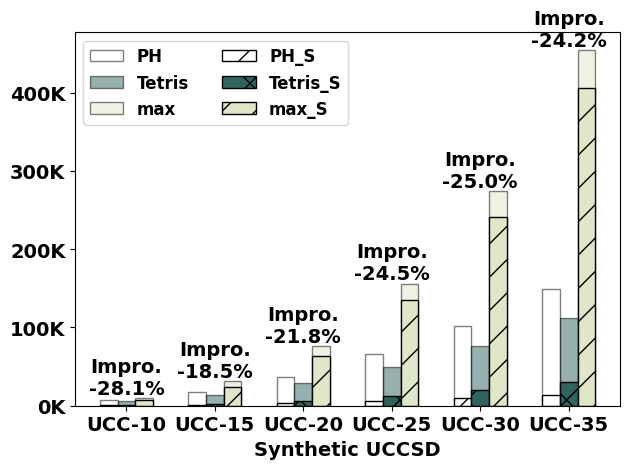

In [11]:
# Sample data
x_values = np.array(['UCC-10', 'UCC-15', 'UCC-20', 'UCC-25', 'UCC-30', 'UCC-35'])  # X-axis values
# benchmarks = x_values
ph_s = []
tetris_s = []
max_cancel_s = []
for i in get_metric_data('Swap_insertion')[6:12]:
    ph_s.append(i[0]*3)
    tetris_s.append(i[1]*3)
    max_cancel_s.append(i[2]*3)

print(ph_s)

ph = []
tetris = []
max_cancel = []
for i in get_metric_data('CNOT')[6:12]:
    ph.append(i[0])
    tetris.append(i[1])
    max_cancel.append(i[2])

print(ph)

width = 0.2  # Width of each bar

# Create a figure and axis
fig, ax = plt.subplots()

# Set the bar positions
x_positions = np.arange(len(x_values))

# Create the bars
# Custom colors for bars (in hexadecimal format)
colors = ['#5ba585', '#30655f', '#e0e7c8']
colors1 = ['#5ba585', '#30655f', '#e0e7c8']

bar1_plot = ax.bar(x_positions - width, ph, width, label='PH',color='w',edgecolor='black',alpha=0.5)
bar2_plot = ax.bar(x_positions, tetris, width, label='Tetris',color=colors[1],edgecolor='black',alpha=0.5)
bar3_plot = ax.bar(x_positions + width, max_cancel, width, label='max',color=colors[2],edgecolor='black',alpha=0.5)

bar4_plot = ax.bar(x_positions - width, ph_s, width, label='PH_S',color='w',edgecolor='black', hatch='/')
bar5_plot = ax.bar(x_positions, tetris_s, width, label='Tetris_S',color=colors1[1],edgecolor='black',hatch='x')
bar6_plot = ax.bar(x_positions + width, max_cancel_s, width, label='max_S',color=colors1[2],edgecolor='black', hatch='/')
if show_imp:
    for i, pos in enumerate(x_positions):
        ax.text(pos, max_cancel[i] + 5, 'Impro.\n{:.1f}%'.format((tetris[i] - ph[i]) * 100 / ph[i]), ha='center', va='bottom', fontsize=14, weight='bold')

plt.gca().yaxis.set_major_formatter(FuncFormatter(format_thousands))
# Set the x-axis labels
ax.set_xticks(x_positions)
ax.set_xticklabels(x_values, fontsize=14,fontweight='bold')  # Set font size for x-axis tick labels

# Set the y-axis label font size
ax.set_ylabel('Values', fontsize=14,fontweight='bold')  # Set font size for y-axis label

# Set the x-axis label font size
ax.set_xlabel('X-Axis', fontsize=14,fontweight='bold')  # Set font size for x-axis label

# Set font size for y-axis tick labels
ax.tick_params(axis='y', labelsize=14)
ytick_labels = ax.get_yticklabels()
for label in ytick_labels:
    label.set_fontweight('bold')
# Add labels and a legend
# ax.set_yscale('log')
# ax.set_ylim(0, 1)
ax.set_xlabel('Synthetic UCCSD')
ax.set_ylabel('')
# ax.set_title('CX Gate Cancel Ratio',fontsize = 15)
# ax.legend(fontsize=13,ncol=2)
legend = plt.legend(fontsize=12,ncol=2)
for text in legend.get_texts():
    text.set_fontweight('bold')
# Show the plot
plt.tight_layout()
plt.savefig('exp_figs/cnot_w_breakdown_uccsd.pdf')
plt.show()

In [12]:

mapper = 'jordan_wigner'
# mapper = 'bravyi_kitaev'
# mapper = 'parity'

PH_data_list = pickle_load(f'runs_final/{mapper}/PH_data.pickle') + pickle_load(f'runs_final/random/PH_data.pickle')
Tetris_data_list = pickle_load(f'runs_final/{mapper}/Tetris_lookahead_data.pickle') + pickle_load(f'runs_final/random/Tetris_lookahead_data.pickle')
Max_cancel_data_list = pickle_load(f'runs_final/{mapper}/Max_cancel_data.pickle') + pickle_load(f'runs_final/random/Max_cancel_data.pickle')
Tetris_without_lh_data_list = pickle_load(f'runs_final/{mapper}/Tetris_data.pickle') + pickle_load(f'runs_final/random/Tetris_data.pickle')


for i, (ph_data, tetris_data, max_cancel_data, tetris_without_lh_data) in enumerate(zip(PH_data_list, Tetris_data_list, Max_cancel_data_list, Tetris_without_lh_data_list)):
    mole, ph = ph_data
    mole, tetris = tetris_data
    mole, max_cancel = max_cancel_data
    mole, tetris_without_lh = tetris_without_lh_data
    categories.append(mole)
    
    original_cx_count = tetris_without_lh['original CNOT count']
    
    ph['CX_cancel_ratio'] = 1.0 - 1.0 * (ph['CNOT'] - ph['PH_swap_count'] * 3) / original_cx_count
    tetris['CX_cancel_ratio'] = 1.0 - 1.0 * (tetris['CNOT'] - tetris['tetris_swap_count'] * 3) / original_cx_count
    max_cancel['CX_cancel_ratio'] = 1.0 - 1.0 * (max_cancel['CNOT'] - max_cancel['tetris_swap_count'] * 3) / original_cx_count
    
    ph['Swap_insertion'] = ph['PH_swap_count']
    tetris['Swap_insertion'] = tetris['tetris_swap_count']
    max_cancel['Swap_insertion'] = max_cancel['tetris_swap_count']
    

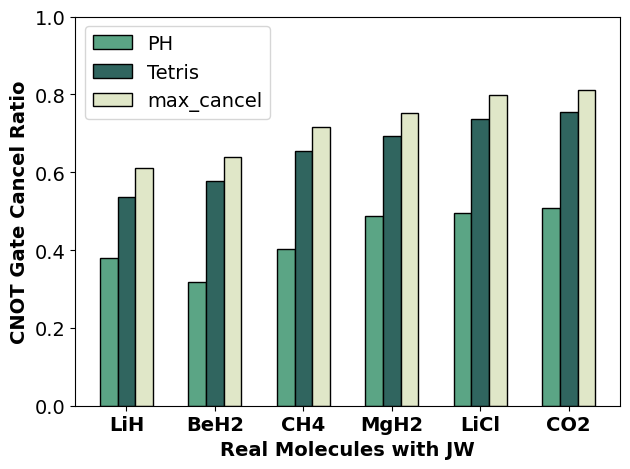

In [13]:
# Sample data
x_values = np.array(['LiH', 'BeH2', 'CH4', 'MgH2', 'LiCl', 'CO2'])  # X-axis values
ph = []
tetris = []
max_cancel = []
for i in get_metric_data('CX_cancel_ratio')[0:6]:
    ph.append(i[0])
    tetris.append(i[1])
    max_cancel.append(i[2])

width = 0.2  # Width of each bar

# Create a figure and axis
fig, ax = plt.subplots()

# Set the bar positions
x_positions = np.arange(len(x_values))

# Create the bars
# Custom colors for bars (in hexadecimal format)
colors = ['#5ba585', '#30655f', '#e0e7c8']
bar1_plot = ax.bar(x_positions - width, ph, width, label='PH',color=colors[0],edgecolor='black')
bar2_plot = ax.bar(x_positions, tetris, width, label='Tetris',color=colors[1],edgecolor='black')
bar3_plot = ax.bar(x_positions + width, max_cancel, width, label='max_cancel',color=colors[2],edgecolor='black')

# Set the x-axis labels
ax.set_xticks(x_positions)
ax.set_xticklabels(x_values, fontsize=14, fontweight='bold')  # Set font size for x-axis tick labels

# Set the y-axis label font size
ax.set_ylabel('Values', fontsize=14,fontweight='bold')  # Set font size for y-axis label

# Set the x-axis label font size
ax.set_xlabel('X-Axis', fontsize=14,fontweight='bold')  # Set font size for x-axis label

# Set font size for y-axis tick labels
ax.tick_params(axis='y', labelsize=14)

# Add labels and a legend
ax.set_ylim(0, 1)
ax.set_xlabel('Real Molecules with JW')
# ax.set_xlabel('Real Molecules with JW')

ax.set_ylabel('CNOT Gate Cancel Ratio')
# ax.set_title('CX Gate Cancel Ratio',fontsize = 15)
ax.legend(fontsize=14)

# Show the plot
plt.tight_layout()
plt.savefig('exp_figs/gcr_molecule_jw.pdf')
plt.show()

[288, 696, 891, 1425, 2931, 4251]
[5300, 15075, 44901, 90291, 225277, 284065]


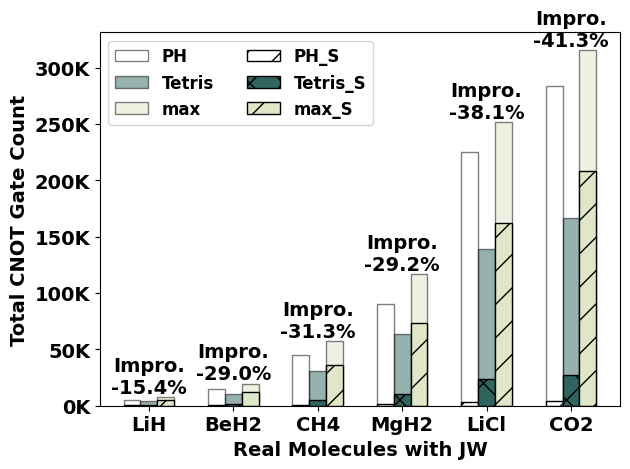

In [14]:
# Sample data
x_values = np.array(['LiH', 'BeH2', 'CH4', 'MgH2', 'LiCl', 'CO2'])  # X-axis values
# benchmarks = x_values
ph_s = []
tetris_s = []
max_cancel_s = []
for i in get_metric_data('Swap_insertion')[0:6]:
    ph_s.append(i[0]*3)
    tetris_s.append(i[1]*3)
    max_cancel_s.append(i[2]*3)

print(ph_s)

ph = []
tetris = []
max_cancel = []
for i in get_metric_data('CNOT')[0:6]:
    ph.append(i[0])
    tetris.append(i[1])
    max_cancel.append(i[2])

print(ph)

width = 0.2  # Width of each bar

# Create a figure and axis
fig, ax = plt.subplots()

# Set the bar positions
x_positions = np.arange(len(x_values))

# Create the bars
# Custom colors for bars (in hexadecimal format)
colors = ['#5ba585', '#30655f', '#e0e7c8']
colors1 = ['#5ba585', '#30655f', '#e0e7c8']

bar1_plot = ax.bar(x_positions - width, ph, width, label='PH',color='w',edgecolor='black',alpha=0.5)
bar2_plot = ax.bar(x_positions, tetris, width, label='Tetris',color=colors[1],edgecolor='black',alpha=0.5)
bar3_plot = ax.bar(x_positions + width, max_cancel, width, label='max',color=colors[2],edgecolor='black',alpha=0.5)

bar4_plot = ax.bar(x_positions - width, ph_s, width, label='PH_S',color='w',edgecolor='black', hatch='/')
bar5_plot = ax.bar(x_positions, tetris_s, width, label='Tetris_S',color=colors1[1],edgecolor='black',hatch='x')
bar6_plot = ax.bar(x_positions + width, max_cancel_s, width, label='max_S',color=colors1[2],edgecolor='black', hatch='/')
if show_imp:
    for i, pos in enumerate(x_positions):
        ax.text(pos, max_cancel[i] + 1, 'Impro.\n{:.1f}%'.format((tetris[i] - ph[i]) * 100 / ph[i]), ha='center', va='bottom', fontsize=14, weight='bold')
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_thousands))

# Set the x-axis labels
ax.set_xticks(x_positions)
ax.set_xticklabels(x_values, fontsize=14,fontweight='bold')  # Set font size for x-axis tick labels

# Set the y-axis label font size
ax.set_ylabel('Values', fontsize=14,fontweight='bold')  # Set font size for y-axis label

# Set the x-axis label font size
ax.set_xlabel('X-Axis', fontsize=14,fontweight='bold')  # Set font size for x-axis label

# Set font size for y-axis tick labels
ax.tick_params(axis='y', labelsize=14)
ytick_labels = ax.get_yticklabels()
for label in ytick_labels:
    label.set_fontweight('bold')
# Add labels and a legend
# ax.set_yscale('log')
# ax.set_ylim(0, 1)
# ax.set_xlabel('Real Molecules with BK')
ax.set_xlabel('Real Molecules with JW')

ax.set_ylabel('Total CNOT Gate Count')
# ax.set_ylabel('')

# ax.set_title('CX Gate Cancel Ratio',fontsize = 15)
# ax.legend(fontsize=10,ncol=2)
legend = plt.legend(fontsize=12,ncol=2)
for text in legend.get_texts():
    text.set_fontweight('bold')
# Show the plot
plt.tight_layout()
plt.savefig('exp_figs/cnot_w_breakdown_molecule_jw.pdf')
# plt.savefig('exp_figs/cnot_w_breakdown_molecule_bk.pdf')

plt.show()

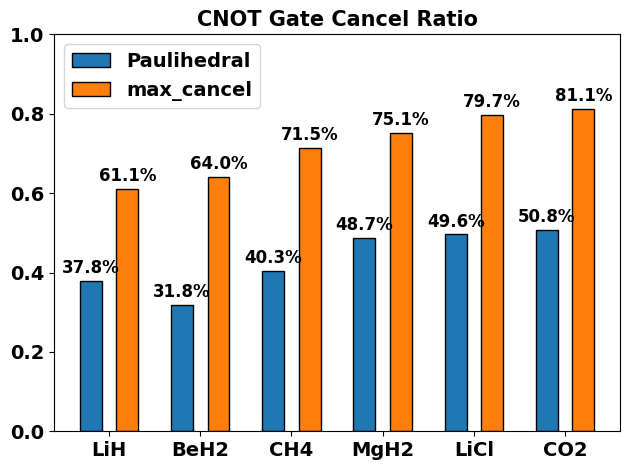

In [15]:
# Sample data
x_values = np.array(['LiH', 'BeH2', 'CH4', 'MgH2', 'LiCl', 'CO2'])  # X-axis values
ph = []
tetris = []
max_cancel = []
for i in get_metric_data('CX_cancel_ratio')[0:6]:
    ph.append(i[0])
    tetris.append(i[1])
    max_cancel.append(i[2])

width = 0.4  # Width of each bar

# Create a figure anax = plt.subplots()
fig, ax = plt.subplots()

# Set the bar positions
x_positions = np.arange(len(x_values))

# Create the bars
# Custom colors for bars (in hexadecimal format)
colors = ['#5ba585', '#30655f', '#e0e7c8']
bar1_plot = ax.bar(x_positions - width/2, ph, width * 0.6, label='Paulihedral',edgecolor='black')
bar3_plot = ax.bar(x_positions + width/2, max_cancel, width * 0.6, label='max_cancel',edgecolor='black')
for i, (ph_gcr, max_cancel_gcr) in enumerate(zip(ph, max_cancel)):
    ax.text(x_positions[i] - width/2, ph_gcr +.01, "{:.1f}%".format(ph_gcr*100.), ha='center', va='bottom', fontsize=12, weight='bold')
    ax.text(x_positions[i] + width/2, max_cancel_gcr + .01, "{:.1f}%".format(max_cancel_gcr*100.), ha='center', va='bottom', fontsize=12, weight='bold')

# Set the x-axis labels
ax.set_xticks(x_positions)
ax.set_xticklabels(x_values, fontsize=14, fontweight='bold')  # Set font size for x-axis tick labels

# Set the y-axis label font size
ax.set_ylabel('Values', fontsize=14,fontweight='bold')  # Set font size for y-axis label

# Set the x-axis label font size
# ax.set_xlabel('X-Axis', fontsize=14,fontweight='bold')  # Set font size for x-axis label

# Set font size for y-axis tick labels
ax.tick_params(axis='y', labelsize=14)
ytick_labels = ax.get_yticklabels()
for label in ytick_labels:
    label.set_fontweight('bold')

# Add labels and a legend
ax.set_ylim(0, 1)
# ax.set_xlabel('Real Molecules with BK')
# ax.set_xlabel('Real Molecules with JW')

ax.set_ylabel('')
ax.set_title('CNOT Gate Cancel Ratio',fontsize = 15, weight='bold')
legend = ax.legend(fontsize=14, loc='upper left')
for text in legend.get_texts():
    text.set_fontweight('bold')

# Show the plot
plt.tight_layout()
plt.savefig('exp_figs/maxCancel_JW.pdf')
plt.show()